### 1. Bag of Word - Benchmarking model


The first step in our analysis is to define a benchmarking model. This will allow us to evaluate afterwards more complex NLP algorithms. In this optic, we will apply test classification, by using one of the basic model, the so called `Bag of Words`. 

In this framework, we will use a sklearn implementation of Bag of Words, `CounterVectorizer` to convert the provided text into a numerical matrics. On top of this matrix, we will than apply `Logistic Regression` and a `Nayve Bayes` algorithm and we will select the one which is providing the best result on a validation data set to predict the test data. 

At the end, we will use the sklearn `Multi Output Classifier` to predict the level of toxicity of the target test within the 5 pre-set labels: `toxic`, `severe toxic`, `obscene`, `threat`, `insult` and `identity hate`. 

#### a. Importing the required libraries

In [1]:
import pandas as pd #import data processing libraries
import numpy as np #import numpy libraries

from statistics import mean 

import string 

#ML Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#To set aproximation to 3 decimals
pd.options.display.float_format = "{:,.2f}".format

#### b. Importing the File

In [2]:
#Reading input csv files
train_text = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")
test_text = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")
sample_submission = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/sample_submission.csv")

train_text.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
train_text.shape

(159571, 8)

In [4]:
test_text.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [5]:
test_text.shape

(153164, 2)

Let's check if there are Null values in the training dataset

In [52]:
# check missing values in numeric columns
train_text.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length
count,"159,571.00","159,571.00","159,571.00","159,571.00","159,571.00","159,571.00","159,571.00"
mean,0.10,0.01,0.05,0.00,0.05,0.01,394.07
std,0.29,0.10,0.22,0.05,0.22,0.09,590.72
min,0.00,0.00,0.00,0.00,0.00,0.00,6.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,96.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,205.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,435.00
max,1.00,1.00,1.00,1.00,1.00,1.00,"5,000.00"


There are no missing numeric values. As the mean values are very small (some way below 0.05), there would be many not labelled as positive in the six categories. From this I guess that there would be many comments which are not labelled in any of the six categories. Let's take a look.

In [16]:
train_text.isnull().any(),test_text.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

Let's analyze the testing data and the labels distribution. 

In [30]:
cols_target = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

# let's see the total rows in train, test data and the numbers for the various categories
print('Total rows in test is {}'.format(len(test_text)))
print('Total rows in train is {}'.format(len(train_text)))
print(train_text[cols_target].sum())

Total rows in test is 153164
Total rows in train is 159571
obscene           8449
insult            7877
toxic            15294
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


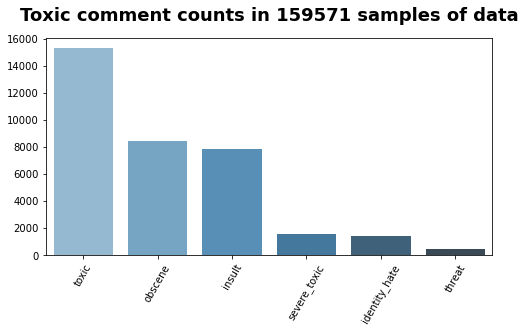

In [21]:
import warnings 

warnings.filterwarnings("ignore")

df_train = train_text.drop(['id', 'comment_text'], axis = 1)
label_counts = df_train.sum()
df_counts = pd.DataFrame(label_counts)
df_counts.rename(columns = {0:'counts'}, inplace = True)
df_counts = df_counts.sort_values('counts', ascending = False)
df_counts 


fig, ax = plt.subplots(figsize = (8,4));
p = sns.barplot(df_counts.index, df_counts['counts'],palette="Blues_d");
x = plt.xticks(rotation = 60); 
ax.set_title('Toxic comment counts in '+ str(len(df_train))+ 
             ' samples of data', weight = 'bold', fontsize = 18, y = 1.05);
x = ax.set_ylabel('');

From the above it is evident that there is an unbalance in the labels distribution, with majority of comments calssified as "toxic". 

It is also interesting to see how many of the Training Text are actually not classified. 

In [53]:
unlabelled_in_all = train_text[(train_text['toxic']!=1) & (train_text['severe_toxic']!=1) & (train_text['obscene']!=1) & 
                            (train_text['threat']!=1) & (train_text['insult']!=1) & (train_text['identity_hate']!=1)]
print('Percentage of unlabelled comments is ', len(unlabelled_in_all)/len(train_text)*100)

Percentage of unlabelled comments is  89.83211235124176


Overall we can recap this with the following code: 

In [54]:
#Looking at the distribution of traget variables
y_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

train_text[y_cols].apply(pd.Series.value_counts, args = (True, True, False, None, False))

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.90,0.99,0.95,1.00,0.95,0.99
1,0.10,0.01,0.05,0.00,0.05,0.01


Based on the above we can notice that we have an anbalance distribution in almost all labels. More specifically, `Toxic Statements`: 10% `Severe Toxic Statements`: 1% `Obscene Statements`: 5% `Threat Statements`: 0.3% `Insult Statements`: 5% `Identity Hate Statements`: 0.9%. As mentioned earlier, majority of the comments in the training data are not labelled in one or more of these categories.

In [57]:
from sklearn.utils import class_weight

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_text[list_classes].values
sample_weights = class_weight.compute_sample_weight('balanced', y)
sample_weights

array([0.01961983, 0.01961983, 0.01961983, ..., 0.01961983, 0.01961983,
       0.01961983])

In [33]:
# Let's look at the character length for the rows in the training data and record these
train_text['char_length'] = train_text['comment_text'].apply(lambda x: len(str(x)))

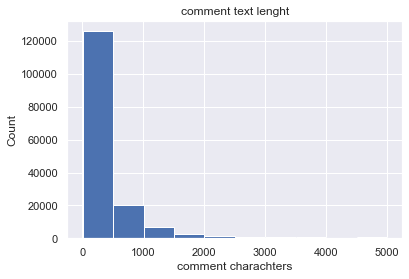

In [62]:
# look at the histogram plot for text length
sns.set()
train_text['char_length'].hist()
plt.title("comment text lenght")
plt.xlabel('comment charachters')
plt.ylabel('Count')
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

Next, let's examine the correlations among the target variables.

In [38]:
data = train_text[cols_target]

<AxesSubplot:title={'center':'Correlation of features & targets'}>

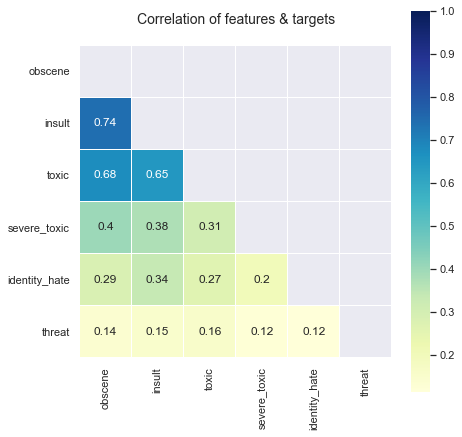

In [50]:
#colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),mask=mask,linewidths=0.1,vmax=1.0,square=True,cmap="YlGnBu",
           linecolor='white',annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

#### c. Splitting the dataset into training and validation sets

In [63]:
#Predictors Variable
X = train_text.comment_text
#Independent Variables
y = train_text[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
#Splitting for checking the performance of the models on a holdout dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle = True, random_state = 123)

In [64]:
X_train.shape, X_val.shape

((119678,), (39893,))

#### d. Basic preprocessing and creation of the Bag of Words

In [65]:
#Let's first remove stopwords are not useful in the prediction of the independent variable
#we will of course the English vocabulary
#we will also remove punctuation

stop_words = _stop_words.ENGLISH_STOP_WORDS

#Function for basic cleaning/preprocessing texts

def clean(txt):
    
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    txt = "".join([char for char in txt if char not in string.punctuation and not char.isdigit()])
    
    # Removal of stopwords
    txt = " ".join([token for token in txt.split() if token not in stop_words])
    
    return txt.lower()


Creating a bag of words model with a limited amount of words (around 5000) to avoid that the dataset is going to be to sparse. We will also clean the dataset.

In [66]:
vect = CountVectorizer(max_features= 5000, preprocessor=clean)

X_train_dtm = vect.fit_transform(X_train)
X_val_dtm = vect.transform(X_val)

print(X_train_dtm.shape, X_val_dtm.shape)

(119678, 5000) (39893, 5000)


5000 is corresponding to the columns which are essentially number of occurences of the 5000 most common words in each sentence.

In [67]:
pd.DataFrame(X_train_dtm.A[:5], columns = vect.get_feature_names())

,abc,abide,ability,able,abortion,about,absence,absolute,absolutely,absurd,...,yourselfgo,youth,youtube,youve,ytmndin,yugoslavia,zealand,zero,zionist,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The above dataframe is showing our Bag of words. For e.g. the word absolutely is in 1st sentence 0 time, which is quite sparse already. 

We will use this dataframe as our imput for our ML Multi Classifier. 

#### e. Initialise and Train the Multi Output Classfier Models

In our use case, we have to classify each sentence if is corresponding to a specific level of toxicity or not, i.e. we will have 6 inputs as the number of pre-set labels. This process is called Multi-Label Classification which is different from multi-class classification, where the prediction has more than 2 options, e.g. postivie, negative, or neutral. 

We will use a MultiOutputClassifier from sklearn which is a wrapper. What we gonna do is basically fit one classifier per target. 

In [68]:
#Let's initialize and fit the model on the Trainign data

#Naive Bayes Model
nb = MultiOutputClassifier(MultinomialNB()).fit(X_train_dtm, y_train)

#Logistic Regression Model 
#(As we have unbalanced dataset, we use class_weight. The “balanced” mode uses the values of y 
#to automatically adjust weights inversely proportional to class frequencies in the input data 
#as n_samples / (n_classes * np.bincount(y)).

lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)) \
                    .fit(X_train_dtm, y_train)

#### f. Measuring performance on Validation data

The Evaluation metrics we will be using is the `ROC-AUC`. We will use this metrics to evaluate all models we will be training. More specifically, we will be using the `predict_proba` function which gives us the probability scores on the prediction. 

In [69]:
#Function for calculating roc-auc with the binary values on the target variables
#and the probability score made by the model

def calculate_roc_auc(y_test, y_pred):
    aucs = []
    
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [70]:
#Creating an empty list of results
results = []

#Making predictions from all the trained models and measure performance for each
for model in [nb,lr]:
    #Extracting name of the model
    est = type(model.estimator).__name__
    #Actual output variables
    y_vals = y_val.to_numpy()
    #Model Probabilities for class 1 of each of the target variables
    y_preds = np.transpose(np.array(model.predict_proba(X_val_dtm))[:,:,1])
    #Calculate Mean of the ROC-AUC
    mean_auc = mean(calculate_roc_auc(y_vals,y_preds))
    #Append the name of the model and the mean_roc_auc into the results list
    results.append([est, mean_auc])
    
#Output the results as a table
pd.DataFrame(results, columns = ["Model","Mean AUC"])

,Model,Mean AUC
0,MultinomialNB,0.94
1,LogisticRegression,0.94


#### g. Predicting test data

In [71]:
#Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(test_text, sample_submission, on = "id")

#Transform the test dataset as well based on Bag of Words/ Count Vectorizer as the Logistic model would 
#expect the same

X_test_dtm = vect.transform(df_test["comment_text"])

#Use the Logistic Regression model to output probabilities and take the probability for class 1
y_preds = np.transpose(np.array(lr.predict_proba(X_test_dtm))[:,:,1])

#Assign the predictions by the model in the final test dataset
df_test[y_cols] = y_preds

#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)

#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission_bag_of_words.csv", index = False)

#### h. Model Interpretation

In order to understand the level of prediction, i.e. to understand the level of prediction, we will use the coefficient values of the Logistic Regression model to get an understanding of the predictions made.

In [18]:
#Assigning the feature names to an empty list
feat_impts = [vect.get_feature_names()]

#For all the models save the feature importances in the list.estimators_ 
#would give the internal models used by the multioutput regressor
for clf in lr.estimators_:
    feat_impts.append(clf.coef_.flatten())
    
#Saving the results in a dataframe
df_feats_impts = pd.DataFrame(np.transpose(np.array(feat_impts)), 
                              columns = ["word","toxic","severe_toxic","obscene","threat","insult","identity_hate"])

#Converting Feature Importance Columns from string to float
df_feats_impts[y_cols] = df_feats_impts[y_cols].astype("float32")
df_feats_impts.head()

,word,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,abc,-0.96,-0.27,-0.78,-1.14,0.14,-0.77
1,abide,-0.71,-0.03,0.31,-0.18,-0.42,-0.15
2,ability,0.31,-0.34,-0.13,-0.33,-0.39,-0.90
3,able,-0.47,-0.47,0.02,-1.49,-0.81,-0.86
4,abortion,-1.37,-0.07,0.56,-0.05,0.58,0.87


We will look at Top 5 words which determine if the sentence is a toxic-type or not according to the model

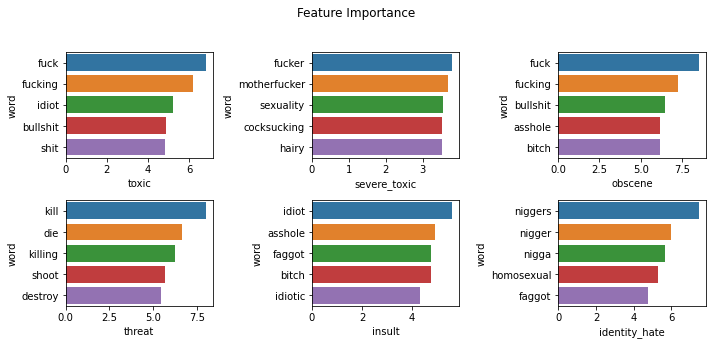

In [19]:
#Creating Individual Feature Importance table by sorting on specific toxic-type column and selecting top 5 words

toxic_fi = df_feats_impts[["word","toxic"]].sort_values(by = "toxic", ascending = False).head()
severe_toxic_fi = df_feats_impts[["word","severe_toxic"]].sort_values(by = "severe_toxic", ascending = False).head()
obscene_fi = df_feats_impts[["word","obscene"]].sort_values(by = "obscene", ascending = False).head()
threat_fi = df_feats_impts[["word","threat"]].sort_values(by = "threat", ascending = False).head()
insult_fi = df_feats_impts[["word","insult"]].sort_values(by = "insult", ascending = False).head()
identity_hate_fi = df_feats_impts[["word","identity_hate"]].sort_values(by = "identity_hate", ascending = False).head()

#Plotting top 5 words based on coefficient values from the LR model
fig,(ax1, ax2) =  plt.subplots(2,3,figsize=(10,5))
sns.barplot(x = "toxic", y = "word", ax = ax1[0], data = toxic_fi)
sns.barplot(x = "severe_toxic", y = "word", ax = ax1[1], data = severe_toxic_fi)
sns.barplot(x = "obscene", y = "word", ax = ax1[2], data = obscene_fi)
sns.barplot(x = "threat", y = "word", ax = ax2[0], data = threat_fi)
sns.barplot(x = "insult", y = "word", ax = ax2[1], data = insult_fi)
sns.barplot(x = "identity_hate", y = "word", ax = ax2[2], data = identity_hate_fi)
plt.suptitle("Feature Importance")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 2. Word2Vec

In this section, we will use an other approach compared to the one we have applied to the Bag of Words. 
Instead of using the `CountVectorizer`, we will use a `Word2Vec` model to create an embedding. Word embeddings give a dense reppresentation in which similar words have similar encodig. 

Embeddings through Word2Vec has proven to be quite sucesfful on many NLP problems. 

#### a. Importing the required libraries

In [2]:
#!pip install ipython-autotime 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from gensim.models import Word2Vec, KeyedVectors

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from tqdm.notebook import tqdm

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from statistics import mean
%load_ext autotime

time: 331 µs (started: 2021-10-10 18:25:14 +02:00)


#### b. Load the Datset

In [3]:
df_train = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")
df_test = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")
sample_submission = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/sample_submission.csv")

time: 1.7 s (started: 2021-10-10 18:25:14 +02:00)


In [4]:
train_texts = list(df_train["comment_text"].values)
train_labels = df_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']].to_numpy()
test_texts = list(df_test["comment_text"].values)
print("Example Training Text:\n\n",train_texts[0])

Example Training Text:

 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
time: 28.9 ms (started: 2021-10-10 18:25:15 +02:00)


We have around 160k training texts and about 153k test texts

#### c. Data Preprocessing

In [5]:
def preprocess_corpus(texts):
    #remove all english stopwords
    
    mystopwords = set(stopwords.words("english"))
    
    def remove_stops_digits(tokens):
        
        #Nested function that lowercases, removes stopwords and digits from a list of tokens
        return [token.lower() for token in tokens if token not in mystopwords and not token.isdigit()
               and token not in punctuation]
    
    #This return statement below uses the above function and tokenizes even further. 
    return [remove_stops_digits(word_tokenize(text)) for text in tqdm(texts)]

#Preprocess both for training and test data

train_texts_processed = preprocess_corpus(train_texts)
test_texts_processed = preprocess_corpus(test_texts)

print("Example Training Prepocessed Text\n\n", train_texts_processed[0])

  0%|          | 0/159571 [00:00<?, ?it/s]

  0%|          | 0/153164 [00:00<?, ?it/s]

Example Training Prepocessed Text

 ['explanation', 'why', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'they', "n't", 'vandalisms', 'closure', 'gas', 'i', 'voted', 'new', 'york', 'dolls', 'fac', 'and', 'please', "n't", 'remove', 'template', 'talk', 'page', 'since', 'i', "'m", 'retired', 'now.89.205.38.27']
time: 2min 48s (started: 2021-10-10 18:25:15 +02:00)


#### d. Load a pre-train embedding model

In [6]:
import gensim

#Path for the models/ embedding vector
filename = '/Users/stefano/UDACITY/Data Engeeniring/Capstone/input/GoogleNews-vectors-negative300.bin.gz'

#Loading the models/ embedding vector using KeyedVectors.load function from gensim
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

time: 53.2 s (started: 2021-10-10 18:28:03 +02:00)


In [7]:
#Print lengths/number of words in the embedding
print(len(model.index_to_key))

3000000
time: 6.74 ms (started: 2021-10-10 18:28:57 +02:00)


Goggle News model/ embedding vector has about 3 M words. Let's have a look at an example of an embedding which is essentialy a dictionary where the key is the word and value is the embedding vector for that word.

In [8]:
#Print Shape of the embedding
print("Shape of embedding vector", model["Natural"].shape)

#Let's print first 20 dimensions rather than all 300
print("First 20 numbers in the embedding of the word Natural\n\n", model["Natural"][:20])

Shape of embedding vector (300,)
First 20 numbers in the embedding of the word Natural

 [-0.22753906 -0.07617188 -0.06787109 -0.1015625   0.20214844  0.12890625
  0.1796875  -0.11035156  0.01123047  0.01794434  0.12402344  0.11132812
 -0.3359375  -0.01104736 -0.16015625 -0.16113281 -0.13769531  0.4296875
 -0.03979492  0.05297852]
time: 17.9 ms (started: 2021-10-10 18:28:57 +02:00)


#### e. Convert text inputs into embeddings using pre trained model

In [9]:
#Function that takes in the input text dataset in form of list of lists where each sentence is a list of words all the sentences are 
#inside a list

def embedding_feats(list_of_lists, DIMENSION, w2v_model):
    zeros_vector = np.zeros(DIMENSION)
    feats = []
    missing = set()
    missing_sentences = set()
    #Traverse over each sentence
    for tokens in tqdm(list_of_lists):
        # Initially assign zeroes as the embedding vector for the sentence
        feat_for_this = zeros_vector
        #Count the number of words in the embedding for this sentence
        count_for_this = 0
        #Traverse over each word of a sentence
        for token in tokens:
            #Check if the word is in the embedding vector
            if token in w2v_model:
                #Add the vector of the word to vector for the sentence
                feat_for_this += w2v_model[token]
                count_for_this +=1
            #Else assign the missing word to missing set just to have a look at it
            else:
                missing.add(token)
        #If no words are found in the embedding for the sentence
        if count_for_this == 0:
            #Assign all zeroes vector for that sentence
            feats.append(feat_for_this)
            #Assign the missing sentence to missing_sentences just to have a look at it
            missing_sentences.add(' '.join(tokens))
        #Else take average of the values of the embedding for each word to get the embedding of the sentence
        else:
            feats.append(feat_for_this/count_for_this)
    return feats, missing, missing_sentences

time: 7.3 ms (started: 2021-10-10 18:28:57 +02:00)


In [10]:
#Embeddings for the train dataset

train_vectors, missing, missing_sentences = embedding_feats(train_texts_processed, 300, model)

  0%|          | 0/159571 [00:12<?, ?it/s]

time: 2min 39s (started: 2021-10-10 18:28:57 +02:00)


In [11]:
print("Shape of the final embeddings for the sentences", np.array(train_vectors).shape)
print("First 20 numbers in the embedding of the first train sentence\n\n", np.array(train_vectors)[0][:20])

Shape of the final embeddings for the sentences (159571, 300)
First 20 numbers in the embedding of the first train sentence

 [ 0.01282094  0.07879842  0.02510173  0.08058929 -0.05929769 -0.0129928
 -0.01726329 -0.09076614  0.07128092  0.0426658  -0.0269399  -0.1129715
 -0.05300395  0.01384761 -0.08168869  0.10279338  0.01549072  0.05962321
  0.03122152 -0.08815613]
time: 998 ms (started: 2021-10-10 18:31:36 +02:00)


To summarize, each sentence will have one 300 dimensional embedding vector which will be an average of the word embeddings present in that sentence. The word embeddings are taken from the pretrained word embeddings that was trained on google news to find the embedding.

#### f. Train and Validate the Multi-Output Classifier

As we are facing a Multi-Label Classification problem, the steps we will apply are: 
    
    1. load the embedding vector from the training dataset;
    2. split the embedding vector into train and validation set;
    3. Apply a LogisticRegression on training embedding vector and output variables
    4. Make prediction and Evaluate the model

In [12]:
#Function for calculating roc auc with given actual binary values across target variables
#and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

time: 624 µs (started: 2021-10-10 18:31:37 +02:00)


In [13]:
def train_model(DIMENSION, model):
    #Get the embedding vector for the training data
    train_vectors, missing, missing_sentences = embedding_feats(train_texts_processed, DIMENSION, model)
    
    #Split the embedding vector for the training data along with the output variables
    #into train and validation sets
    train_data, val_data, train_cats, val_cats = train_test_split(train_vectors, train_labels)
    
    #Logistic Regression Model (As we have unbalanced dataset, we use class_weight which will use inverse
    #of counts of that class. It penalizes mistakes in samples of class[i] with class_weight[i] instead of 1)
    lr = MultiOutputClassifier(LogisticRegression(class_weight='balanced', max_iter=3000)).fit(train_data, train_cats)
    
    #Actuals for the validation data
    y_vals = val_cats
    #Prediction probability for the validation dataset by the model for class 1
    y_preds = np.transpose(np.array(lr.predict_proba(val_data))[:,:,1])
    #Calculate the Mean ROC_AUC 
    mean_auc = mean(accuracy(y_vals,y_preds))
    return mean_auc, lr

time: 4.07 ms (started: 2021-10-10 18:31:37 +02:00)


In [14]:
mean_auc, lr = train_model(300, model)
print(mean_auc)

  0%|          | 0/159571 [00:00<?, ?it/s]

0.5695784673882687
time: 1min 22s (started: 2021-10-10 18:31:37 +02:00)


This model turns out to be pretty moderate. This might be because of the pretrained embeddings not correctly capturing the details. We could instead train an embedding of our own using Word2Vec.

In [15]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(df_test, sample_submission, on = "id")

#Getting the embedding matrix for test texts 
test_vectors, _, _ = embedding_feats(test_texts_processed, 300, model)

#Use the Logistic Regression model to output probabilities and take the probability for class 1
y_preds = np.transpose(np.array(lr.predict_proba(test_vectors))[:,:,1])

#Assign the predictions by the model in the final test dataset
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = y_preds

#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)

#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission_word2vec.csv", index = False)

  0%|          | 0/153164 [00:00<?, ?it/s]

time: 1min 9s (started: 2021-10-10 18:33:00 +02:00)


### 3. FastText

In this section we wil use an other model developed by Facebook, which is still built around the concept of embeddings. The main difference compared to the word2vec is that we will avoid the problem of OOV. OOV means Out of Vocabulary. It is litteraly the case in which we add a new word in the test data for which we may be needed a new embeddings. The word2vec is basically skipping this word, while FastText is trying to get an embedding also for the OOV word. 

#### a. Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
from statistics import mean

from fasttext import train_supervised

#Sklearn Library
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from tqdm.notebook import tqdm

#### b. Load the dataset

In [3]:
train_text = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")
test_text = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")
sample_submission = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/sample_submission.csv")

print(train_text.shape, test_text.shape, sample_submission.shape)
train_text.head()

(159571, 8) (153164, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### c. Splitting dataset into training and validation

In [4]:
y_cols = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
X = train_text.comment_text
y = train_text[y_cols]

train, val = train_test_split(train_text, shuffle = True, random_state = 123)

#### d. Pre processing data

In this section we will clean and prepare the testing data for FastText. 

1. we remove some punctuaction by replacing it with a space and remove the "\n" as quite present in the testing dataset;

2. we do unicode normalization

3. we convert the binary labels into __class0__ and __class 1__ as FastText use this vocabulary for prediction

4. We will shuffle the data set to introduce some randomess

In [6]:
# Lets do some cleaning of this text
def clean_it(text,normalize=True):
    # Replacing possible issues with data. We can add or reduce the replacemtent in this chain
    s = str(text).replace(',',' ').replace('"','').replace('\'',' \' ').replace('.',' . ').replace('(',' ( ').\
            replace(')',' ) ').replace('!',' ! ').replace('?',' ? ').replace(':',' ').replace(';',' ').lower()
    s = s.replace("\n"," ")
    
    # normalizing / encoding the text
    if normalize:
        s = s.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')
    
    return s

# Now lets define a small function where we can use above cleaning on datasets
def clean_df(data, cleanit= False, shuffleit=False, encodeit=False, label_prefix='__class__'):
    # Defining the new data
    df = data[['comment_text']].copy(deep=True)
    for col in y_cols:
        df[col] = label_prefix + data[col].astype(str) + ' '
    
    # cleaning it
    if cleanit:
        df['comment_text'] = df['comment_text'].apply(lambda x: clean_it(x,encodeit))
    
    # shuffling it
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)
            
    return df

# Transform the datasets using the above clean functions
df_train_cleaned = clean_df(train, True, True)
df_val_cleaned = clean_df(val, True, True, label_prefix='')

In [7]:
df_train_cleaned.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
141599,a quote many psychometricians and behavio...,__class__0,__class__0,__class__0,__class__0,__class__0,__class__0
86692,and right at the time of making such allegati...,__class__0,__class__0,__class__0,__class__0,__class__0,__class__0
28863,formally not de facto yes . and in the end ...,__class__0,__class__0,__class__0,__class__0,__class__0,__class__0
14048,religious groups why is the only religion is...,__class__0,__class__0,__class__0,__class__0,__class__0,__class__0
78005,the doctor suggests it ' s probably something...,__class__0,__class__0,__class__0,__class__0,__class__0,__class__0


In [8]:
df_val_cleaned.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
50446,and redirect the other names to it,0,0,0,0,0,0
81571,sinebot1 please read the above comments .,0,0,0,0,0,0
25983,thank you for your very good answer . i just...,0,0,0,0,0,0
39022,i think we need to ask who is likely to be v...,0,0,0,0,0,0
49431,orangemonster2k1|svrtvdude]] ( vt ) 23 26 3...,0,0,0,0,0,0


We have not changed the labels for the validation set, as we are not processing it through FastText. 

#### e. Training the model

- we cannot use the Multi-Output Classifier wrapper as FasText is accepting as input only csv file;

- train_supervised will be the function use in this model. By tunning the hyperparameters we can try to improve the model;

- In FasText, we can evaluate the model only by calculating the probabilities for each sentence, one sentence at a time. Therfore, to calculate the ROC-AUC, we will need a loop to store the probabilties in an empty list. 


In [9]:
#Will contain all the predictions for validation set for all the output variables
all_preds = []
#Iterating over all output variables to create separate models
for col in tqdm(y_cols):
    #Path for saving the training dataset
    train_file = '/Users/stefano/UDACITY/Data Engeeniring/Capstone/working/final_train.csv'
    #Saving the Output Variable and the text data to a csv
    df_train_cleaned[[col, "comment_text"]].to_csv(train_file, header=None, index=False, columns=[col, "comment_text"]) 
    #Training the model
    model = train_supervised(input=train_file, label="__class__", lr=1.0, epoch=2, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)
    #Predictions for validation sets for that ouput variable
    col_preds = []
    #Iterating over each sentence in the validation set
    for text in df_val_cleaned["comment_text"].values:
        #Get the prediction for class 1
        pred = model.predict(text, k = 2)[1][1]
        #Append the prediction to the list of predictions for that output variable
        col_preds.append(pred)
    #Append the list of predictions for a output variable to the overall set of predictions for all columns
    all_preds.append(col_preds)

  0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
#Function for calculating roc auc with given actual binary values across target variables and the probability score made by the model
def accuracy(y_test, y_pred):
    aucs = []
    #Calculate the ROC-AUC for each of the target column
    for col in range(y_test.shape[1]):
        aucs.append(roc_auc_score(y_test[:,col],y_pred[:,col]))
    return aucs

In [11]:
#Actual Labels
y_val_actuals = df_val_cleaned[y_cols].astype("int").to_numpy()
#Prediction probability - minor ordering
all_preds_array = np.transpose(np.array(all_preds))
#Calculate the mean of the ROC-AUC for each of the ouput variable
mean_auc = mean(accuracy(y_val_actuals,all_preds_array))
mean_auc

0.7654310278918564

The ROC-AUC on the validation set has a precision of around 0.77, which is definitely better than the Word2Vec model. 
This is also true if we consider that we have just used 2 epoch and not-tuned any parameter. Moreover the prediction has been quite quick in terms of prediction time.

#### f. Predictin and Submittin Test data

In [12]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(test_text, sample_submission, on = "id")

# Preprocessing the test dataset as well
df_test_cleaned = clean_df(df_test, True, True, label_prefix='')

#Will contain all the predictions for validation set for all the output variables
all_test_preds = []
for col in tqdm(y_cols):
    
    #Predictions for test sets for that ouput variable
    col_preds = []
    
    #Iterating over each sentence in the test set
    for text in df_test_cleaned["comment_text"].values:
        
        #Get the prediction for class 1
        pred = model.predict(text, k = 2)[1][1]
        
        #Append the prediction to the list of predictions for that output variable
        col_preds.append(pred)
        
    #Append the list of predictions for a output variable to the overall set of predictions for all columns
    all_test_preds.append(col_preds)
    
#Prediction probability - minor ordering
all_test_preds_array = np.transpose(np.array(all_test_preds))

#Assign the predictions by the model in the final test dataset
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = all_test_preds_array

#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)

#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission.csv", index = False)

  0%|          | 0/6 [00:00<?, ?it/s]

### 4. CNN

In this part of the notebook, we will use a Convolutional Neural Networks (CNNs) for multi-label text classification by using keras libraries.

#### a. Importing the required libraries

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, Embedding, Input

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

#### b. Loading the dataset

In [17]:
df_train = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")
df_test = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")
sample_submission = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/sample_submission.csv")

In [18]:
#Assinging the texts to list of strings
train_texts= df_train.comment_text.values
test_texts= df_test.comment_text.values
#Assignings the labels as a separate df
train_labels = df_train[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
#Printing the list of strings
print("First comment text in training set:\n\n", train_texts[0])

First comment text in training set:

 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


#### c. Text Preprocessing


In order to process an input in a CNNs model, we need to transform this input into a number. Keras provides provides some basic tool to process data and prepare them for CNNs. We will use Tokenizer class, that will transform the text into a vector, by transforming each text into a sequence of integers or into a vector where the coefficient of each token will be binary. To do this we will have to perform 3 main steps: 

1. Initializing the Tokenizer class:

    All puntuactions is removed, than sentences are splitted into sequences of words to be than splitted into tokens. We will than index this tokens. 0 is the resereved parameter to be assigned to any words. We set num_words to MAX_NUM_WORDS (20000) which is the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.


2. Calling the fit_on_texts function - Updates internal vocabulary based on a list of texts

    This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

3. Calling the texts_to_sequences function - Transforms each text in texts to a sequence of integers

    So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

    N.B. After fit_on_texts, which is essentially creating a word_index matrix for the vocabulary, we could do 2 things

    texts_to_sequences which is used when we use a embedding layer otherwise we can call

    text_to_matrix which converts the texts to a bag of words

In [19]:
#Initializing the class
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
#Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(train_texts)
#Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print("Length of word Index:", len(word_index))
print("First 5 elements in the word_index dictionary:", dict(list(word_index.items())[0: 5]) )
print("First comment text in training set:\n", train_sequences[0])

Length of word Index: 210337
First 5 elements in the word_index dictionary: {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5}
First comment text in training set:
 [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


Now that we have tokenized the comment texts, we need to pad the sentences to make all the sentences of equal length.

Why So?

Deep learning libraries assume a vectorized representation of your data. In the case of variable length sequence prediction problems, this requires that your data be transformed such that each sequence has the same length. This vectorization allows code to efficiently perform the matrix operations in batch for your chosen deep learning algorithms.

This is also done in Computer Vision, where we generally tend to resize all the images to a fixed size which will be the input size of the Neural Network.

In [20]:
#Pad tokenized sequences
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of padded sequence list:\n", trainvalid_data.shape)
print("First comment text in training set - 0 for padding - only last 50 sequences as the rest are paddings:\n", trainvalid_data[0][-50:])

Shape of padded sequence list:
 (159571, 1000)
First comment text in training set - 0 for padding - only last 50 sequences as the rest are paddings:
 [    0     0     0   688    75     1   126   130   177    29   672  4511
 12052  1116    86   331    51  2278 11448    50  6864    15    60  2756
   148     7  2937    34   117  1221 15190  2825     4    45    59   244
     1   365    31     1    38    27   143    73  3462    89  3085  4583
  2273   985]


#### d. Text Preprocessing

In Kears the easiest way to define a CNNs model is to initiate a Sequential model class and keep adding required layers at occurance.

A standard model for document classification is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer, and then a prediction output layer. We will be using, 1 embedding layer, 3 sets of Convolution and Pooling layer and 2 sets of Dense layer


Conv1D

Convolutional Neural Network (CNN) models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels. This same process can be applied to 1D sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. CNNs take into account the proximity of words to create trainable patterns. The kernel size/height in the convolutional layer defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter. In our case, it will consider 5 words at a time and in the image it will consider 2 words at a time.

4. Defining a 1D CNN model
In keras, the easiest way to define a model is initiate a Sequential model class and keep adding required layers. A Sequential model is a plain stack of layers where each layer has exactly one input tensor and one output tensor.

A standard model for document classification is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer, and then a prediction output layer. We used 1 embedding layer, 3 sets of Convolution and Pooling layer and 2 sets of Dense layer. We can either use a pre-trained embedding (like Word2Vec) to generate a embedding matrix of size Vocabulary * Dimension of embedding or train a fresh embedding putting it as an input layer along with other weights.

Conv1D

Convolutional Neural Network (CNN) models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels. This same process can be applied to 1D sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. CNNs take into account the proximity of words to create trainable patterns. The kernel size/height in the convolutional layer defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter. In our case, it will consider 5 words at a time and in the image it will consider 2 words at a time



**Max Pooling 1D**

Max Pooling layer will consolidate the output from the convolutional layer. We had earlier seen MaxPooling 2D. In Maxpooling 1D, the same thing happens only in 1 direction.

We use sigmoid activation in the output layer. Sigmoid function gives us a probability score between 0 and 1 from each out of the output node. If we would have used softmax it gives a probability distribution across the output nodes that adds to 1.

In general,

For binary classification, we can have 1 output units, use sigmoid activation in the output layer and use binary cross entropy loss
For multi class classification, we can have N output units, use softmax activation in the output layer and use categorical cross entropy loss
For multi label classification, we can have N output units, use sigmoid activation in the output layer and use binary cross entropy loss

In [21]:
cnn_model = Sequential()
cnn_model.add(Embedding(MAX_NUM_WORDS, 128))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(MaxPooling1D(pool_size = 5))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(MaxPooling1D(pool_size = 5))
cnn_model.add(Conv1D(filters = 128, kernel_size = 5, activation = "relu"))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(units = 128, activation = 'relu'))
cnn_model.add(Dense(units = 6, activation = 'sigmoid'))

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0

#### e. Compile the Model

Before starting to train the model, we need to configure it. We need to mention the loss fucntion which will be used to calculate the error at each iteration, optimizer which will specify how the weights will be updated and the metrics which is to be evaluated by the model during training and testing

While fitting/ training the model, along with the training set we also pass the following parameters:

batch_size = Number of samples that goes through the network at a time and updates the network parameters by calculating loss (in Mini Batch Gradient Descent)

epochs = Number of times the whole set of training samples goes through the network

validation_data = the dataset that will be used to evaluate the loss and any model metrics at the end of each epoch. This set will not be used for training.

In [22]:
#Configures the model for training.
cnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])

#Split the dataset into train and validation set for training and evaludating the model
X_train, X_val, y_train, y_val = train_test_split(trainvalid_data, train_labels, shuffle = True, random_state = 123)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
#Trains the model for a fixed number of epochs (iterations on a dataset)
history = cnn_model.fit(X_train, y_train, batch_size = 128, epochs = 1, validation_data = (X_val, y_val))

(119678, 1000) (119678, 6) (39893, 1000) (39893, 6)
935/935 [==============================] - 544s 561ms/step - loss: 0.1265 - auc: 0.8648 - val_loss: 0.0543 - val_auc: 0.9765


#### f. Predicting and submitting the test model

In [23]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(df_test, sample_submission, on = "id")
#Use the CNN model to output probabilities on test data
y_preds = cnn_model.predict(test_data)
#Assign the predictions by the model in the final test dataset
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = y_preds
#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)
#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission.csv", index = False)

### 5. LSTM

In this part of the notebook, we will introduce a Long Short Term Memory (LSTM) model, which is an improvement over the regular RNNs model for multi-label text classification.

#### a. Load Library

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#sklearn libraries
from sklearn.model_selection import train_test_split
#keras libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Input
#Constants
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

#### b. Load the dataset

In [26]:
df_train = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/train.csv")
df_test = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/test.csv")
sample_submission = pd.read_csv("/Users/stefano/UDACITY/Data Engeeniring/Capstone/Data/sample_submission.csv")

print(df_train.shape, df_test.shape, sample_submission.shape)
df_train.head()

(159571, 8) (153164, 2) (153164, 7)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [27]:
#Assinging the texts to list of strings
train_texts= df_train.comment_text.values
test_texts= df_test.comment_text.values
#Assignings the labels as a separate df
train_labels = df_train[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]]
#Printing the list of strings
print("First comment text in training set:\n\n", train_texts[0])

First comment text in training set:

 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


#### c. Pre-processing data

In [28]:
#Initializing the class
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
#Updates internal vocabulary based on a list of texts.
tokenizer.fit_on_texts(train_texts)
#Transforms each text in texts to a sequence of integers.
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print("Length of word Index:", len(word_index))
print("First 5 elements in the word_index dictionary:", dict(list(word_index.items())[0: 5]) )
print("First comment text in training set:\n", train_sequences[0])

Length of word Index: 210337
First 5 elements in the word_index dictionary: {'the': 1, 'to': 2, 'of': 3, 'and': 4, 'a': 5}
First comment text in training set:
 [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]


In [29]:
#Pad tokenized sequences
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of padded sequence list:\n", trainvalid_data.shape)
print("First comment text in training set - 0 for padding - only last 50 sequences as the rest are paddings:\n", trainvalid_data[0][-50:])

Shape of padded sequence list:
 (159571, 1000)
First comment text in training set - 0 for padding - only last 50 sequences as the rest are paddings:
 [    0     0     0   688    75     1   126   130   177    29   672  4511
 12052  1116    86   331    51  2278 11448    50  6864    15    60  2756
   148     7  2937    34   117  1221 15190  2825     4    45    59   244
     1   365    31     1    38    27   143    73  3462    89  3085  4583
  2273   985]


#### d. Create the LSTM model

In [30]:
rnn_model = Sequential()
rnn_model.add(Embedding(MAX_NUM_WORDS, 128))
rnn_model.add(LSTM(units = 128, dropout = 0.2, recurrent_dropout = 0.2))
rnn_model.add(Dense(units = 6, activation = 'sigmoid'))
print(rnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 2,692,358
Trainable params: 2,692,358
Non-trainable params: 0
_________________________________________________________________
None


#### e. Train the model

In [31]:
#Configures the model for training.
rnn_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["AUC"])

#Split the dataset into train and validation set for training and evaludating the model
X_train, X_val, y_train, y_val = train_test_split(trainvalid_data, train_labels, shuffle = True, random_state = 123)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

#Trains the model for a fixed number of epochs (iterations on a dataset)
history = rnn_model.fit(X_train, y_train, batch_size = 128, epochs = 1, validation_data = (X_val, y_val))

(119678, 1000) (119678, 6) (39893, 1000) (39893, 6)
935/935 [==============================] - 2910s 3s/step - loss: 0.1444 - auc: 0.8239 - val_loss: 0.0524 - val_auc: 0.9759


#### f. Predicting and submitting test data

In [32]:
# Merging the test dataset with sample_submission to have all the columns:
#id,text_data and the target variables in one dataframe
df_test = pd.merge(df_test, sample_submission, on = "id")
#Use the CNN model to output probabilities on test data
y_preds = rnn_model.predict(test_data)
#Assign the predictions by the model in the final test dataset
df_test[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = y_preds
#Drop Comment Text as the sample submission doesnt have it and wouldnt be expected
df_test.drop(["comment_text"], axis = 1, inplace = True)
#Save the dataset as a csv to submit it
df_test.to_csv("sample_submission.csv", index = False)

We have decided to run the BERT model on a separate notebook, as it will be trained one the Google Colab workspace to laverage GPU power. 